# <div align="center"> Pizza Runner Project </div> 
### <div align="center"> SQL Code and Information: *<a href="https://8weeksqlchallenge.com/case-study-2/">8 Week SQL Challenge - Pizza Runner</a>*</div>

This is the 2<sup>nd</sup> week in the *SQL Challenge*. It focuses on a lot more metrics and encourages us to analyze the relationships between variables, more than just running basic queries. 


### Table of Contents:
- [Data Cleaning](#data-cleaning)
- [Pizza Metrics](#pizza-metrics)
- [Runner and Customer Experience](#runner-and-customer-experience)
- [Ingredient Optimization](#ingredient-optimization)
- [Pricing and Ratings](#pricing-and-ratings)



## Data Cleaning
My VSCode is connected to my Postgresql Server, so this is how I added this information and ***cleaned the data*** before writing queries:

1. Created DB named Pizza_Runner
2. Added tables and data to db
3. Then, I went into my pgAdmin and exported the tables into CSV files.
4. I used spreadsheets to clean the data, for example:
    - In runner_orders, I changed the data formats for distance, duration, and pickup_time so each cell matched each other within that column
    - In customer_orders, I changed all ID columns to numeric and order_time to timestamp
        - In both of these tables I made sure that those columns that said null were blank
    - In the other tables, I made sure nothing was null or blank and that the data types were appropriate for the data within the columns.
5. Before I imported these files back into SQL, I had to delete the information from the the tables:
    - ```DELETE FROM [table_name]```
6. Then, I imported these files back and ran a few basic queries to double check all of the information

#### <div align="center"> Before and After Cleaning Examples </div>


# Analysis

## Pizza Metrics
### Questions to Answer:

1.	How many unique customer orders were made?
2.	How many unique customer orders were made?
3.	How many successful orders were delivered by each runner?
4.	How many of each type of pizza was delivered?
5.	How many Vegetarian and Meat-lovers were ordered by each customer?
6.	What was the maximum number of pizzas delivered in a single order?
7.	For each customer, how many pizzas delivered had at least 1 change and how many had no changes?
8.	How many pizzas were delivered that had both exclusions and extras?
9.	What was the total volume of pizzas ordered for each hour of the day?
10.	What was the volume of orders for each day of the week?


#### Question 1: How many unique customer orders were made?
```
SELECT
    COUNT(DISTINCT order_id) as UniqueOrders
FROM
    customer_orders
```

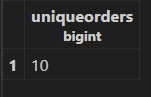

#### Question 2: How many of each pizza type were delivered per runner
```
SELECT
    public.runner_orders.runner_id,
    (
        CASE
            when pizza_id = 1 then 'Veg'
            else 'Meat'
        end
    ) AS PizzaType,
    COUNT(public.customer_orders.pizza_id) as PizzaTypePerRunner
FROM
    public.customer_orders
    JOIN public.runner_orders ON public.customer_orders.order_id = public.runner_orders.order_id
WHERE
    public.runner_orders.cancellation IS NULL
GROUP BY
    PizzaType,
    public.runner_orders.runner_id
ORDER BY
    public.runner_orders.runner_id
```

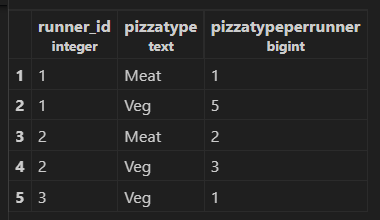

#### Question 3: How many veg and meat were ordered per customer?
```
SELECT
    customer_orders.order_id,
    (
        CASE
            when pizza_id = 1 then 'Veg'
            else 'Meat-Lovers'
        end
    ) AS PizzaType,
    COUNT(customer_orders.pizza_id) as NumberPerOrder
FROM
    customer_orders
    JOIN runner_orders ON customer_orders.order_id = runner_orders.order_id
WHERE
    cancellation IS NULL
GROUP BY
    PizzaType,
    customer_orders.order_id
ORDER BY
    customer_orders.order_id
```

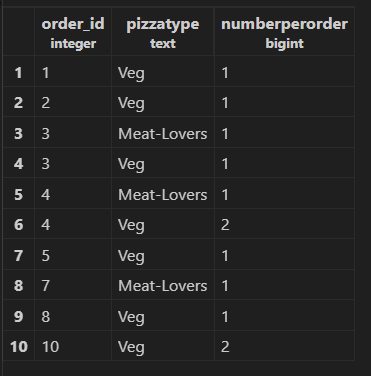



#### Question 4: What was the max number of pizzas delivered in 1 order?
```
SELECT
    customer_orders.order_id,
    COUNT(customer_orders.pizza_id) as MaxNumPizzaPerOrder
FROM
    customer_orders
    JOIN runner_orders ON customer_orders.order_id = runner_orders.order_id
WHERE
    cancellation IS NULL
GROUP BY
    customer_orders.order_id
ORDER BY
    MaxNumPizzaPerOrder DESC
Limit
    1
```

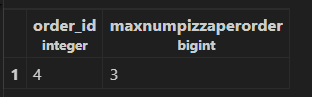

#### Question 5: Show 1 change vs no changes per customer.
```
SELECT
    customer_orders.order_id,
    (
        case
            when extras = 'null' then 'no changes'
            when extras = '1' then '1 change'
            else NULL
        end
    ) AS Changes
FROM
    customer_orders
WHERE
    changes IS NOT NULL
GROUP BY
    customer_orders.order_id,
    Changes
ORDER BY
    customer_orders.order_id
```



#### Question 6: How many pizzas were delivered that had both exclusions and extras?
```
SELECT
    customer_orders.order_id,
    COUNT(
        case
            WHEN NOT exclusions = 'null'
            AND NOT extras = 'null' then 'Both exclusions and extras'
            else NULL
        end
    ) as Changes
FROM
    customer_orders
    JOIN runner_orders ON customer_orders.order_id = runner_orders.order_id
WHERE
    cancellation IS NULL
GROUP BY
    customer_orders.order_id
```

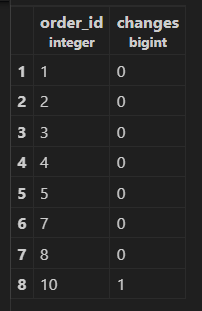

#### Question 7: What was the total volume of pizzas ordered for each hour of the day?
```
SELECT
    COUNT(order_id) AS pizzaCount,
    hours
FROM
    (
        SELECT
            order_id,
            date_trunc('hour', runner_orders.pickup_time) AS hours
        FROM
            public.runner_orders
    ) AS innerTable
WHERE
    hours IS NOT NULL
GROUP BY
    hours
ORDER BY
    hours
```

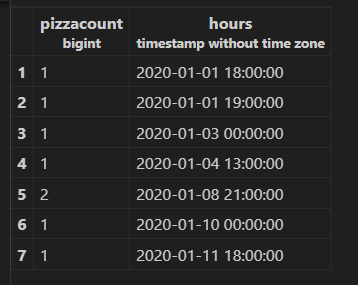

#### Question 8: What was the volume of orders for each day of the week?
```
SELECT
    weekday,
    COUNT(order_id)
FROM
    (
        SELECT
            order_id,
            to_char(pickup_time, 'Day') AS weekday
        FROM
            public.runner_orders
    ) AS innerTable
WHERE
    weekday IS NOT NULL
GROUP BY
    weekday
ORDER BY
    array_position(
        ARRAY['Wednesday', 'Friday', 'Saturday']::text[],
        weekday
    )
```

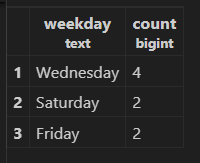

## Runner and Customer Experience
### Questions to Answer:

1.	How many runners signed up for each 1-week period? (i.e. week starts 2021-01-01)
2.	What was the average time in minutes it took for each runner to arrive at the Pizza Runner HQ to pick up the order?
3.	Is there any relationship between the number of pizzas and how long the order takes to prepare?
4.	What was the average distance travelled for each customer?
5.	What was the difference between the longest and shortest delivery times for all orders?
6.	What was the average speed for each runner for each delivery and do you notice any trend for these values?
7.	What is the successful delivery percentage for each runner?


#### Question 1: How many runners signed up for each 1-week period
```
SELECT (case
when pickup_time BETWEEN '2020-01-01' AND '2020-01-07' then 1
when pickup_time BETWEEN '2020-01-08' AND '2020-01-14' then 2
else 3
end
) AS Week, COUNT(DISTINCT(runner_id)) AS numOfRunners
FROM public.runner_orders
GROUP BY Week
ORDER BY Week
```

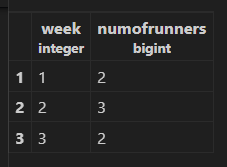

#### Question 2: What was the average time in minutes it took for each runner to arrive at the Pizza Runner HQ to pick up the order?

```
SELECT runner_id, AVG(runner_orders.pickup_time - customer_orders.order_time)
FROM public.customer_orders
JOIN public.runner_orders ON customer_orders.order_id=runner_orders.order_id
WHERE cancellation IS NULL
GROUP BY runner_id
```

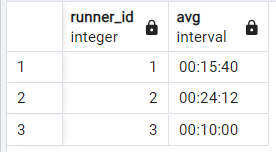

#### Question 3: Is there any relationship between the number of pizzas and how long the order takes to prepare?
```
SELECT
    order_id,
    COUNT(pizza_id) as MaxNumPizzaPerOrder,
	prep_time
FROM
    (
        SELECT
            customer_orders.order_id, customer_orders.pizza_id, runner_orders.cancellation,
            (runner_orders.pickup_time - customer_orders.order_time) AS prep_time
        FROM
            public.	runner_orders
    JOIN customer_orders ON runner_orders.order_id = customer_orders.order_id
	) AS innerTable
WHERE
	cancellation IS NULL
GROUP BY
    order_id, prep_time
ORDER BY
    MaxNumPizzaPerOrder

```

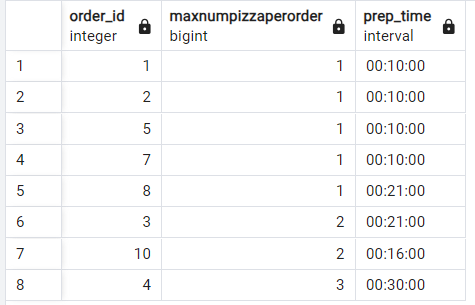

#### Question 4: What was the average distance travelled for each customer?
```
SELECT customer_id, AVG(runner_orders.distance)
FROM public.customer_orders
JOIN public.runner_orders ON customer_orders.order_id=runner_orders.order_id
WHERE cancellation IS NULL
GROUP BY customer_id
```
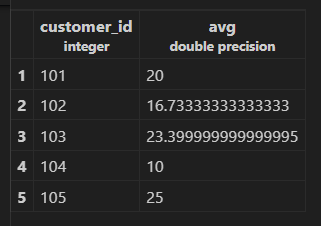


#### Question 5: What was the difference between the longest and shortest delivery times for all orders?

```
SELECT *
FROM 
(
SELECT (MAX(duration)-MIN(duration)) as diffBetweenDeliveries
FROM public.runner_orders
)
```

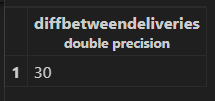

#### Question 6: What was the average speed for each runner for each delivery and do you notice any trend for these values?

/*I ran this to show COUNT(order_id), COUNT(pizza_id), and AVG(distance) and compared the three relationships, I found that the average distance correlated the most to the average duration of each runner, pizza_id and order_id were the same output*/

```
SELECT runner_orders.runner_id, COUNT(customer_orders.pizza_id)as pizzaCount, AVG(distance) as distance, AVG(duration) as avgDuration
FROM public.runner_orders
JOIN public.customer_orders on runner_orders.order_id=customer_orders.order_id
WHERE cancellation IS NULL
GROUP BY runner_orders.runner_id
ORDER BY runner_orders.runner_id
```

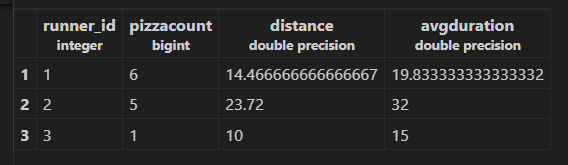


#### Question 7: What is the successful delivery percentage for each runner?
```
SELECT *
FROM (
    SELECT 
        runner_id, 
        COUNT(order_id) AS totalOrders,
        COUNT(CASE 
                WHEN cancellation IS NULL THEN 1 
                ELSE NULL 
             END) AS SuccessfulDeliveries,
        (COUNT(CASE 
                WHEN cancellation IS NULL THEN 1 
                ELSE NULL 
             END) * 1.0 / COUNT(order_id)) AS succPercentage
    FROM public.runner_orders
    GROUP BY runner_id
) sub
```
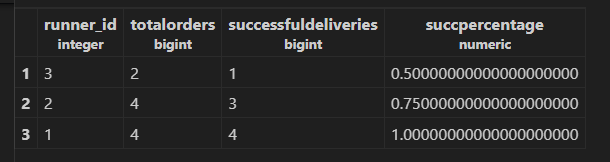


## Ingredient Optimization
### Questions to Answer:

1.	What are the standard ingredients for each pizza?
2.	What was the most commonly added extra?
3.	What was the most common exclusion?
4.	Generate an order item for each record in the customer_orders table in the format of one of the following:
    - Meat Lovers
    - Meat Lovers - Exclude Beef
    - Meat Lovers - Extra Bacon
    - Meat Lovers - Exclude Cheese, Bacon - Extra Mushroom, Peppers
6.	Generate an alphabetically ordered comma separated ingredient list for each pizza order from the customer_orders table and add a 2x in front of any relevant ingredients
    - For example: "Meat Lovers: 2xBacon, Beef, ... , Salami"
7.	What is the total quantity of each ingredient used in all delivered pizzas sorted by most frequent first?


#### Questions 1: What are the standard ingredients for each pizza?
I created this query using standard SQL and had to translate it so BigQuery could run it for me. The first query is my rough draft query and the second one is the query I ran to get the shown results.

Standard SQL:
```
WITH new_topping_table AS (
SELECT pizza_id, topping_id
FROM pizza_recipes
    CROSS APPLY STRING_SPLIT(toppings, ',')
)
SELECT pizza_id,
    GROUP_CONCAT(',', pizza_toppings.topping_name,  ORDER BY pizza_toppings.topping_name) as toppings_list
FROM new_topping_table
INNER JOIN pizza_toppings
    ON new_topping_table.topping_id = pizza_toppings.topping_id
GROUP BY pizza_id
ORDER BY pizza_id
```

BigQuery Translation:
```
WITH new_topping_table AS (
SELECT pizza_id, CAST(split_topping AS INT64) AS topping_id
FROM involuted-river-436122-a7.pizza_runner.pizza_recipes , UNNEST(SPLIT(toppings, ', ')) AS split_topping
)
SELECT pizza_id, STRING_AGG(`involuted-river-436122-a7.pizza_runner.pizza_toppings`.topping_name, ',' ORDER BY `involuted-river-436122-a7.pizza_runner.pizza_toppings`.topping_name) as toppings_list FROM new_topping_table
INNER JOIN `involuted-river-436122-a7.pizza_runner.pizza_toppings` ON new_topping_table.topping_id = `involuted-river-436122-a7.pizza_runner.pizza_toppings`.topping_id
GROUP BY pizza_id
ORDER BY pizza_id
```

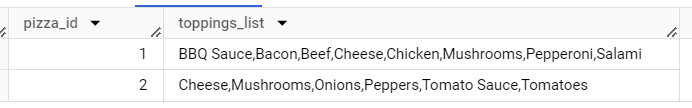

#### Question 2: What was the most commonly added extra?


```
WITH new_extras_table AS (
SELECT pizza_id, CAST(split_extra AS INT64) AS topping_id
FROM `involuted-river-436122-a7.pizza_runner.customer_orders`, UNNEST(SPLIT(extras, ', ')) AS split_extra
WHERE extras IS NOT NULL
)
SELECT `involuted-river-436122-a7.pizza_runner.pizza_toppings`.topping_id, `involuted-river-436122-a7.pizza_runner.pizza_toppings`.topping_name, COUNT(new_extras_table.topping_id) as pop_extras FROM new_extras_table
INNER JOIN `involuted-river-436122-a7.pizza_runner.pizza_toppings` 
  ON new_extras_table.topping_id = `involuted-river-436122-a7.pizza_runner.pizza_toppings`.topping_id
GROUP BY topping_id, topping_name
ORDER BY pop_extras DESC;
```

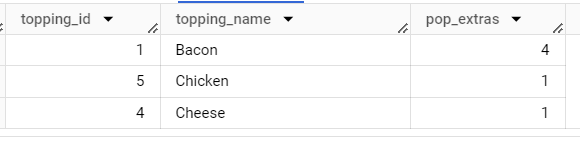

#### Question 3: What was the most common exclusion?


```
WITH new_exc_table AS (
SELECT pizza_id, CAST(split_exclusions AS INT64) AS topping_id
FROM `involuted-river-436122-a7.pizza_runner.customer_orders`, UNNEST(SPLIT(exclusions, ', ')) AS split_exclusions
WHERE exclusions IS NOT NULL
)
SELECT `involuted-river-436122-a7.pizza_runner.pizza_toppings`.topping_id, `involuted-river-436122-a7.pizza_runner.pizza_toppings`.topping_name, COUNT(new_exc_table.topping_id) as pop_excl FROM new_exc_table
INNER JOIN `involuted-river-436122-a7.pizza_runner.pizza_toppings` 
  ON new_exc_table.topping_id = `involuted-river-436122-a7.pizza_runner.pizza_toppings`.topping_id
GROUP BY topping_id, topping_name
ORDER BY pop_excl DESC;
```

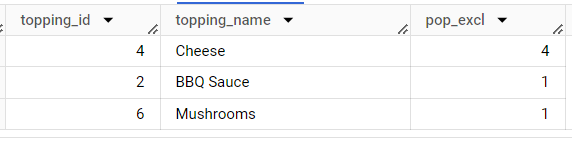

#### Question 4: Generate an order item for each record in the customer_orders table in the format of one of the following:
- Meat Lovers
- Meat Lovers - Exclude Beef
- Meat Lovers - Extra Bacon
- Meat Lovers - Exclude Cheese, Bacon - Extra Mushroom, Peppers


```
SELECT * FROM `involuted-river-436122-a7.pizza_runner.customer_orders`
UNION ALL
SELECT 1, 101, 1, NULL, NULL, NULL
UNION ALL
SELECT 2, 101, 1, '3', NULL, NULL
UNION ALL
SELECT 3, 102, 1, NULL, NULL, NULL
UNION ALL
SELECT 4, 103, 1, '1, 4', '6, 9', NULL
UNION ALL
SELECT 5, 104, 1, '3', NULL, NULL
UNION ALL
SELECT 6, 101, 1, NULL, NULL, NULL
UNION ALL
SELECT 7, 105, 1, '1, 4', '6, 9', NULL
UNION ALL
SELECT 8, 102, 1, '3', NULL, NULL
UNION ALL
SELECT 9, 103, 1, NULL, NULL, NULL
UNION ALL
SELECT 10, 104, 1, NULL, '1', NULL;

```

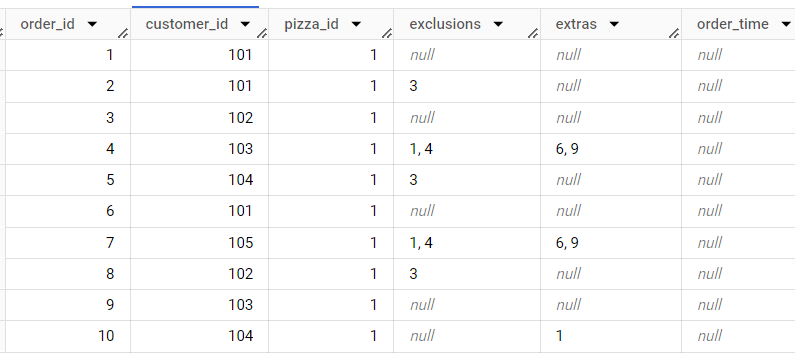

#### Question 5: Generate an alphabetically ordered comma separated ingredient list for each pizza order from the customer_orders table and add a 2x in front of any relevant ingredients
- For example: "Meat Lovers: 2xBacon, Beef, ... , Salami"


```

```


#### Question 6: What is the total quantity of each ingredient used in all delivered pizzas sorted by most frequent first?

## Pricing and Ratings
### Questions to Answer:

1.	If a Meat Lovers pizza costs \\$12 and Vegetarian costs \\$10 and there were no charges for changes - how much money has Pizza Runner made so far if there are no delivery fees?
2.	What if there was an additional \\$1 charge for any pizza extras?
    - Add cheese is \\$1 extra
3.	The Pizza Runner team now wants to add an additional ratings system that allows customers to rate their runner, how would you design an additional table for this new dataset - generate a schema for this new table and insert your own data for ratings for each successful customer order between 1 to 5.
4.	Using your newly generated table - can you join all of the information together to form a table which has the following information for successful deliveries?
- customer_id
- order_id
- runner_id
- rating
- order_time
- pickup_time
- Time between order and pickup
- Delivery duration
- Average speed
- Total number of pizzas

5.	If a Meat Lovers pizza was \\$12 and Vegetarian \\$10 fixed prices with no cost for extras and each runner is paid \\$0.30 per kilometre traveled - how much money does Pizza Runner have left over after these deliveries?


#### Question 1: If a Meat Lovers pizza costs \\$12 and Vegetarian costs \\$10 and there were no charges for changes - how much money has Pizza Runner made so far if there are no delivery fees?

```
SELECT
SUM(CASE
    WHEN `involuted-river-436122-a7.pizza_runner.customer_orders`.pizza_id=1 THEN 12
    WHEN `involuted-river-436122-a7.pizza_runner.customer_orders`.pizza_id=2 THEN 10
    END) as Total_Price
from `involuted-river-436122-a7.pizza_runner.customer_orders`
INNER JOIN `involuted-river-436122-a7.pizza_runner.runner_orders` ON `involuted-river-436122-a7.pizza_runner.customer_orders`.order_id=`involuted-river-436122-a7.pizza_runner.runner_orders`.order_id
WHERE `involuted-river-436122-a7.pizza_runner.runner_orders`.cancellation IS NULL;
```

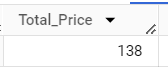

#### Question 2: What if there was an additional \\$1 charge for any pizza extras?

```
WITH price_table AS ( 
SELECT
SUM(CASE
    WHEN pizza_id=1 THEN 12
    WHEN pizza_id=2 THEN 10
END) as basic_price,
SUM(CASE
    WHEN extras LIKE '_' THEN 1
    WHEN extras LIKE '_, _' THEN 2
END) AS additions
FROM `involuted-river-436122-a7.pizza_runner.customer_orders`
INNER JOIN `involuted-river-436122-a7.pizza_runner.runner_orders` ON `involuted-river-436122-a7.pizza_runner.customer_orders`.order_id=`involuted-river-436122-a7.pizza_runner.runner_orders`.order_id
WHERE `involuted-river-436122-a7.pizza_runner.runner_orders`.cancellation IS NULL
)
SELECT SUM(basic_price + additions) AS Total_price
from price_table;
```
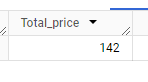


#### Question 3: 
The Pizza Runner team now wants to add an additional ratings system that allows customers to rate their runner, how would you design an additional table for this new dataset - generate a schema for this new table and insert your own data for ratings for each successful customer order between 1 to 5.

I chose to inherit a similar schema from the runner_orders table and calculate the ratings based on the speed of delivery. We are not aware of the quality of the food and how the customer experienced the order, so the best we can do for the delivery people is base them on their speed since we have the distance and duration of each successful delivery.

First, I created the information I wanted for the table by calculating the rating system and choosing the data I wanted from the runner_orders table:
```
WITH speed_calc AS (
    SELECT order_id, pickup_time, distance, duration, runner_id, ((distance/duration) * 100) as speed_per_runner
    FROM `involuted-river-436122-a7.pizza_runner.runner_orders`
    WHERE cancellation IS NULL
)

SELECT runner_id, order_id, pickup_time, distance, duration,
    (CASE
        WHEN speed_per_runner < 50 THEN 1
        WHEN speed_per_runner BETWEEN 50 AND 69 THEN 2
        WHEN speed_per_runner BETWEEN 70 AND 89 THEN 3
        WHEN speed_per_runner BETWEEN 90 AND 110 THEN 4
        WHEN speed_per_runner >= 111 THEN 5
    END) AS rating
FROM speed_calc
```

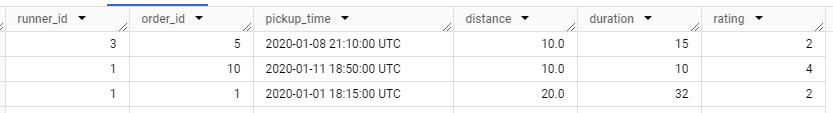

I have been using BigQuery for this project and it allows me to create a table based on query results, so that is exactly what I did here:

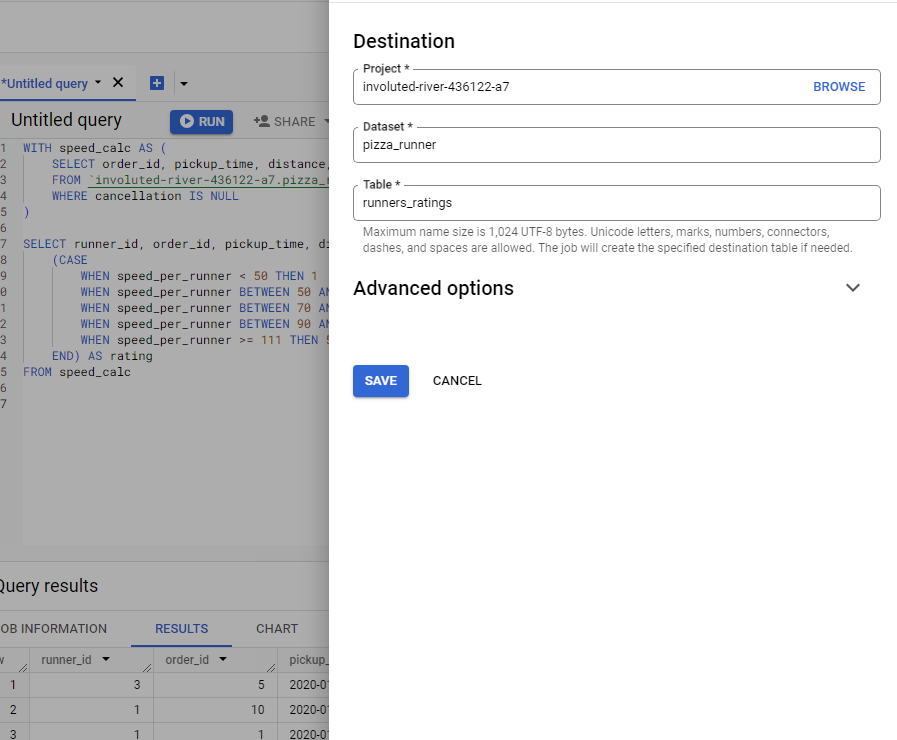


#### Question 4: If a Meat Lovers pizza was \\$12 and Vegetarian \\$10 fixed prices with no cost for extras and each runner is paid \\$0.30 per kilometre traveled - how much money does Pizza Runner have left over after these deliveries?

## Bonus Question
If Danny wants to expand his range of pizzas - how would this impact the existing data design? Write an INSERT statement to demonstrate what would happen if a new Supreme pizza with all the toppings was added to the Pizza Runner menu?